1. mon_standard.pkl > array code

In [2]:
import pickle
import sys
from tqdm import tqdm # For the progress bar

# 1. Loading
print("Loading file (this may take a few seconds)...")
with open("mon_standard.pkl", 'rb') as fi:
    data = pickle.load(fi)

USE_SUBLABEL = False
URL_PER_SITE = 10
# Automatically calculate the actual size
TOTAL_URLS = len(data)
print(f"File loaded! Number of entries: {TOTAL_URLS}")

X1_mon = []
X2_mon = []
y_mon = []

print("Processing data...")

# Using tqdm to see the progress bar
for i in tqdm(range(TOTAL_URLS), desc="Conversion"):
    # Label logic (unchanged)
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE 
    
    # Inner loop (unchanged)
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        y_mon.append(label)

# Delete 'data' because we copied everything into X1 and X2.
# This immediately releases RAM.
del data 
print("Memory cleaned ('data' variable deleted).")

size = len(y_mon)
print(f'Total final samples: {size}')

Loading file (this may take a few seconds)...
File loaded! Number of entries: 950
Processing data...


Conversion: 100%|██████████| 950/950 [03:11<00:00,  4.96it/s]

Memory cleaned ('data' variable deleted).
Total final samples: 19000


2. unmon_standard10.pkl > array code

In [3]:
import pickle
import numpy as np
from tqdm import tqdm # For the progress bar

# Load unmon pickle file
print("Loading datafile...")
with open('unmon_standard10.pkl', 'rb') as f:
    x = pickle.load(f)

# 1. Dynamic size
TOTAL_URLS = len(x)
print(f'Total samples in file: {TOTAL_URLS}')

X1_unmon = [] 
X2_unmon = [] 

print("Processing unmonitored data...")

# 2. Loop with progress bar (tqdm)
for i in tqdm(range(TOTAL_URLS), desc="Unmon Conversion"):
    size_seq = []
    time_seq = []
    # Original logic preserved
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) 
    
    # Add to lists
    X1_unmon.append(np.array(time_seq, dtype=np.int32))
    X2_unmon.append(np.array(size_seq, dtype=np.int16))

# 3. Memory cleanup
del x
print("Memory cleaned (variable 'x' deleted).")

print(f"Final X1 length: {len(X1_unmon)}") 

# Print an element to check (Note: index 0-10 equals -10, i.e., the 10th from the end)
if len(X2_unmon) > 10:
    print(X2_unmon[0-10])

Loading datafile...
Total samples in file: 10000
Processing unmonitored data...


Unmon Conversion: 100%|██████████| 10000/10000 [00:18<00:00, 531.90it/s]


Memory cleaned (variable 'x' deleted).
Final X1 length: 10000
[-512 -512  512 ... -512 -512 -512]


### Data Preprocessing ###

#### Remove corrupted/incomplete traces


In [4]:
def clean(X1, X2, y=None):
    X1_clean, X2_clean, y_clean = [], [], []
    for i in range(len(X1)):
        if len(X1[i]) > 0 and len(X1[i]) == len(X2[i]): # non-empty & matching lengths
            X1_clean.append(X1[i])
            X2_clean.append(X2[i])
            if y is not None:
                y_clean.append(y[i])
    return (X1_clean, X2_clean, y_clean) if y is not None else (X1_clean, X2_clean)

# clean monitored
X1_mon, X2_mon, y_mon = clean(X1_mon, X2_mon, y_mon)
print("Clean monitored traces:", len(X1_mon))

# clean unmonitored
X1_unmon, X2_unmon = clean(X1_unmon, X2_unmon)
print("Clean unmonitored traces:", len(X1_unmon))

Clean monitored traces: 19000
Clean unmonitored traces: 10000


#### Normalize timestamps to start at 0

In [5]:
def normalize_timestamps(X1):
    return [[t - seq[0] for t in seq] for seq in X1] # subtract by first seq value for each value to see how much time passed in each packet

X1_mon = normalize_timestamps(X1_mon)
X1_unmon = normalize_timestamps(X1_unmon)

#### Truncate or pad sequences to certain length

In [6]:
import numpy as np

MAX_LEN = 10000

def pad_truncate(seq, max_len=10000):
    seq = list(seq)  # assure une liste Python

    if len(seq) > max_len:
        return seq[:max_len]

    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))

    return seq

# --- MONITORED --------------------------------------------------------------
X1_mon = np.array([pad_truncate(s, MAX_LEN) for s in X1_mon])
X2_mon = np.array([pad_truncate(s, MAX_LEN) for s in X2_mon])
y_mon = np.array(y_mon)

# --- UNMONITORED ------------------------------------------------------------
X1_unmon = np.array([pad_truncate(s, MAX_LEN) for s in X1_unmon])
X2_unmon = np.array([pad_truncate(s, MAX_LEN) for s in X2_unmon])

print("\nMonitored timestamps:", X1_mon.shape)
print("Unmonitored timestamps:", X1_unmon.shape)



Monitored timestamps: (19000, 10000)
Unmonitored timestamps: (10000, 10000)


#### Split data into training, testing, and validation datasets

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1) SCENARIO CLOSED WORLD

X1_train_cw, X1_temp_cw, X2_train_cw, X2_temp_cw, y_train_cw, y_temp_cw = train_test_split(
    X1_mon, X2_mon, y_mon,
    test_size=0.30,
    stratify=y_mon,
    random_state=42
)

X1_val_cw, X1_test_cw, X2_val_cw, X2_test_cw, y_val_cw, y_test_cw = train_test_split(
    X1_temp_cw, X2_temp_cw, y_temp_cw,
    test_size=0.50,
    stratify=y_temp_cw,
    random_state=42
)

# 2) SCENARIO OPEN WORLD (binary 0/1)

y_mon_binary = np.ones(len(X1_mon))        # Surveillé = 1
y_unmon_binary = np.zeros(len(X1_unmon))   # Non-surveillé = 0

# Combine les données
X1_all = np.vstack((X1_mon, X1_unmon))
X2_all = np.vstack((X2_mon, X2_unmon))
y_all  = np.concatenate((y_mon_binary, y_unmon_binary))

# Split open world
X1_train_ow, X1_temp_ow, X2_train_ow, X2_temp_ow, y_train_ow, y_temp_ow = train_test_split(
    X1_all, X2_all, y_all,
    test_size=0.30,
    stratify=y_all,
    random_state=42
)

X1_val_ow, X1_test_ow, X2_val_ow, X2_test_ow, y_val_ow, y_test_ow = train_test_split(
    X1_temp_ow, X2_temp_ow, y_temp_ow,
    test_size=0.50,
    stratify=y_temp_ow,
    random_state=42
)

## **FEATURE EXTRACTION** (Alexandre)

In [8]:
import numpy as np
from collections import Counter

def extract_all_features(X1, X2):
    all_features = []
    
    for idx in range(len(X1)):
        # Remove padding (zeros)
        time_seq = X1[idx][X1[idx] != 0]
        size_seq = X2[idx][X2[idx] != 0]
        
        # Handle empty sequences
        if len(time_seq) == 0 or len(size_seq) == 0:
            # Return zero features for empty sequences
            all_features.append([0] * 80)
            continue
        
        feature_dict = {}
        
        # ====================================================================
        # 1. STATISTICAL FEATURES
        # ====================================================================
        
        # Basic counts
        feature_dict['total_packets'] = len(size_seq)
        feature_dict['incoming_packets'] = np.sum(size_seq < 0)
        feature_dict['outgoing_packets'] = np.sum(size_seq > 0)
        
        # Byte statistics
        feature_dict['total_bytes_in'] = np.sum(np.abs(size_seq[size_seq < 0]))
        feature_dict['total_bytes_out'] = np.sum(size_seq[size_seq > 0])
        feature_dict['total_bytes'] = np.sum(np.abs(size_seq))
        
        # Packet size statistics
        abs_sizes = np.abs(size_seq)
        feature_dict['mean_packet_size'] = np.mean(abs_sizes)
        feature_dict['std_packet_size'] = np.std(abs_sizes)
        feature_dict['median_packet_size'] = np.median(abs_sizes)
        feature_dict['max_packet_size'] = np.max(abs_sizes)
        feature_dict['min_packet_size'] = np.min(abs_sizes)
        
        # Ratios
        feature_dict['in_out_packet_ratio'] = (feature_dict['incoming_packets'] / max(feature_dict['outgoing_packets'], 1))
        feature_dict['in_out_byte_ratio'] = (feature_dict['total_bytes_in'] / max(feature_dict['total_bytes_out'], 1))
        
        # ====================================================================
        # 2. BURST FEATURES
        # ====================================================================
        
        # Identify bursts (consecutive packets in same direction)
        directions = np.sign(size_seq)
        direction_changes = np.concatenate([[True], np.diff(directions) != 0])
        burst_indices = np.where(direction_changes)[0]
        
        # Split into bursts
        bursts = np.split(size_seq, burst_indices[1:])
        burst_times = np.split(time_seq, burst_indices[1:])
        
        # Burst lengths (number of packets per burst)
        burst_lengths = [len(b) for b in bursts]
        
        # Burst sizes (total bytes per burst)
        burst_sizes = [np.sum(np.abs(b)) for b in bursts]
        
        # Burst durations (time span)
        burst_durations = []
        for bt in burst_times:
            if len(bt) > 1:
                burst_durations.append(bt[-1] - bt[0])
            else:
                burst_durations.append(0)
        
        # Burst statistics
        feature_dict['num_bursts'] = len(bursts)
        feature_dict['max_burst_length'] = np.max(burst_lengths) if burst_lengths else 0
        feature_dict['avg_burst_length'] = np.mean(burst_lengths) if burst_lengths else 0
        feature_dict['std_burst_length'] = np.std(burst_lengths) if len(burst_lengths) > 1 else 0
        
        feature_dict['max_burst_size'] = np.max(burst_sizes) if burst_sizes else 0
        feature_dict['avg_burst_size'] = np.mean(burst_sizes) if burst_sizes else 0
        feature_dict['std_burst_size'] = np.std(burst_sizes) if len(burst_sizes) > 1 else 0
        
        feature_dict['max_burst_duration'] = np.max(burst_durations) if burst_durations else 0
        feature_dict['avg_burst_duration'] = np.mean(burst_durations) if burst_durations else 0
        
        # Incoming vs outgoing bursts
        incoming_bursts = [b for b in bursts if b[0] < 0]
        outgoing_bursts = [b for b in bursts if b[0] > 0]
        
        feature_dict['num_incoming_bursts'] = len(incoming_bursts)
        feature_dict['num_outgoing_bursts'] = len(outgoing_bursts)
        
        # ====================================================================
        # 3. TIMING FEATURES
        # ====================================================================
        
        # Session duration
        feature_dict['session_duration'] = time_seq[-1] - time_seq[0]
        
        # Inter-packet delays
        if len(time_seq) > 1:
            inter_packet_delays = np.diff(time_seq)
            
            feature_dict['mean_delay'] = np.mean(inter_packet_delays)
            feature_dict['std_delay'] = np.std(inter_packet_delays)
            feature_dict['median_delay'] = np.median(inter_packet_delays)
            feature_dict['min_delay'] = np.min(inter_packet_delays)
            feature_dict['max_delay'] = np.max(inter_packet_delays)
            
            # Percentiles
            feature_dict['percentile_10_delay'] = np.percentile(inter_packet_delays, 10)
            feature_dict['percentile_25_delay'] = np.percentile(inter_packet_delays, 25)
            feature_dict['percentile_50_delay'] = np.percentile(inter_packet_delays, 50)
            feature_dict['percentile_75_delay'] = np.percentile(inter_packet_delays, 75)
            feature_dict['percentile_90_delay'] = np.percentile(inter_packet_delays, 90)
            
            # Time to first incoming packet
            first_incoming_idx = np.where(size_seq < 0)[0]
            if len(first_incoming_idx) > 0:
                feature_dict['time_to_first_incoming'] = time_seq[first_incoming_idx[0]]
            else:
                feature_dict['time_to_first_incoming'] = 0
        else:
            # Single packet - set timing features to 0
            for k in ['mean_delay', 'std_delay', 'median_delay', 'min_delay', 'max_delay',
                      'percentile_10_delay', 'percentile_25_delay', 'percentile_50_delay',
                      'percentile_75_delay', 'percentile_90_delay', 'time_to_first_incoming']:
                feature_dict[k] = 0
        
        # ====================================================================
        # 4. DIRECTIONAL PATTERN FEATURES
        # ====================================================================
        
        # Number of direction changes
        feature_dict['direction_changes'] = np.sum(direction_changes) - 1  # -1 because first is always True
        
        # Average length of unidirectional sequences (same as avg burst length)
        feature_dict['avg_unidirectional_length'] = feature_dict['avg_burst_length']
        
        # First outgoing burst characteristics
        if len(outgoing_bursts) > 0:
            feature_dict['first_outgoing_burst_size'] = np.sum(outgoing_bursts[0])
            feature_dict['first_outgoing_burst_length'] = len(outgoing_bursts[0])
        else:
            feature_dict['first_outgoing_burst_size'] = 0
            feature_dict['first_outgoing_burst_length'] = 0
        
        # Traffic concentration (packets in first/last 20%)
        split_20 = len(size_seq) // 5
        split_80 = (4 * len(size_seq)) // 5
        
        feature_dict['packets_first_20_percent'] = split_20
        feature_dict['packets_last_20_percent'] = len(size_seq) - split_80
        
        # Ratio of outgoing to incoming in different segments
        # Beginning (first 30%)
        split_30 = len(size_seq) // 3
        early_out = np.sum(size_seq[:split_30] > 0)
        early_in = np.sum(size_seq[:split_30] < 0)
        feature_dict['early_out_in_ratio'] = early_out / max(early_in, 1)
        
        # Middle (30%-70%)
        split_70 = (7 * len(size_seq)) // 10
        mid_out = np.sum(size_seq[split_30:split_70] > 0)
        mid_in = np.sum(size_seq[split_30:split_70] < 0)
        feature_dict['mid_out_in_ratio'] = mid_out / max(mid_in, 1)
        
        # End (last 30%)
        late_out = np.sum(size_seq[split_70:] > 0)
        late_in = np.sum(size_seq[split_70:] < 0)
        feature_dict['late_out_in_ratio'] = late_out / max(late_in, 1)
        
        # ====================================================================
        # 5. SEQUENCE-BASED FEATURES
        # ====================================================================
        
        # First K packet directions (K=20)
        K = 20
        first_k_directions = directions[:min(K, len(directions))]
        
        # Count patterns in first K
        feature_dict['first_k_incoming'] = np.sum(first_k_directions == -1)
        feature_dict['first_k_outgoing'] = np.sum(first_k_directions == 1)
        
        # N-grams of directional patterns (bigrams and trigrams)
        # Convert directions to string for n-gram extraction
        dir_string = ''.join(['O' if d > 0 else 'I' for d in directions])
        
        # Bigrams (pairs)
        if len(dir_string) >= 2:
            bigrams = [dir_string[i:i+2] for i in range(len(dir_string)-1)]
            bigram_counts = Counter(bigrams)
            
            feature_dict['bigram_OO'] = bigram_counts.get('OO', 0)
            feature_dict['bigram_OI'] = bigram_counts.get('OI', 0)
            feature_dict['bigram_IO'] = bigram_counts.get('IO', 0)
            feature_dict['bigram_II'] = bigram_counts.get('II', 0)
        else:
            feature_dict['bigram_OO'] = 0
            feature_dict['bigram_OI'] = 0
            feature_dict['bigram_IO'] = 0
            feature_dict['bigram_II'] = 0
        
        # Trigrams (triples)
        if len(dir_string) >= 3:
            trigrams = [dir_string[i:i+3] for i in range(len(dir_string)-2)]
            trigram_counts = Counter(trigrams)
            
            feature_dict['trigram_OOO'] = trigram_counts.get('OOO', 0)
            feature_dict['trigram_III'] = trigram_counts.get('III', 0)
            feature_dict['trigram_OOI'] = trigram_counts.get('OOI', 0)
            feature_dict['trigram_IOO'] = trigram_counts.get('IOO', 0)
        else:
            feature_dict['trigram_OOO'] = 0
            feature_dict['trigram_III'] = 0
            feature_dict['trigram_OOI'] = 0
            feature_dict['trigram_IOO'] = 0
        
        if feature_dict['session_duration'] > 0:
            num_windows = 10
            window_size = feature_dict['session_duration'] / num_windows
            cumulative_bytes = np.zeros(num_windows)
            
            for i, t in enumerate(time_seq):
                window_idx = min(int(t / window_size), num_windows - 1)
                cumulative_bytes[window_idx] += abs(size_seq[i])
            
            # Normalize cumulative bytes
            if np.sum(cumulative_bytes) > 0:
                cumulative_bytes = cumulative_bytes / np.sum(cumulative_bytes)
            
            for i in range(num_windows):
                feature_dict[f'cumulative_bytes_window_{i}'] = cumulative_bytes[i]
        else:
            for i in range(10):
                feature_dict[f'cumulative_bytes_window_{i}'] = 0
        
        # Convert to list
        all_features.append(list(feature_dict.values()))
    
    # Get feature names from the first non-empty sample
    feature_names = list(feature_dict.keys())
    
    return np.array(all_features), feature_names

In [9]:
from sklearn.preprocessing import StandardScaler

print("Extracting features...")

# CLOSED WORLD
X_train_cw_features, feature_names = extract_all_features(X1_train_cw, X2_train_cw)
X_val_cw_features, _ = extract_all_features(X1_val_cw, X2_val_cw)
X_test_cw_features, _ = extract_all_features(X1_test_cw, X2_test_cw)

# OPEN WORLD
X_train_ow_features, _ = extract_all_features(X1_train_ow, X2_train_ow)
X_val_ow_features, _ = extract_all_features(X1_val_ow, X2_val_ow)
X_test_ow_features, _ = extract_all_features(X1_test_ow, X2_test_ow)

print(f"✓ {len(feature_names)} features extracted")

# SCALING
scaler_cw = StandardScaler()
X_train_cw_scaled = scaler_cw.fit_transform(X_train_cw_features)
X_val_cw_scaled = scaler_cw.transform(X_val_cw_features)
X_test_cw_scaled = scaler_cw.transform(X_test_cw_features)

scaler_ow = StandardScaler()
X_train_ow_scaled = scaler_ow.fit_transform(X_train_ow_features)
X_val_ow_scaled = scaler_ow.transform(X_val_ow_features)
X_test_ow_scaled = scaler_ow.transform(X_test_ow_features)

print("✓ Features scaled")

Extracting features...
✓ 65 features extracted
✓ Features scaled


## **KNN MODEL** (Alice)

In [10]:
from sklearn.preprocessing import StandardScaler

# --- Closed World Scaler ---
scaler_cw = StandardScaler()

# Fit only on CW training features
scaler_cw.fit(X_train_cw_features)

# Transform
X_train_cw_scaled = scaler_cw.transform(X_train_cw_features)
X_val_cw_scaled   = scaler_cw.transform(X_val_cw_features)
X_test_cw_scaled  = scaler_cw.transform(X_test_cw_features)

# --- Open World Scaler ---
scaler_ow = StandardScaler()

# Fit only on OW training features
scaler_ow.fit(X_train_ow_features)

# Transform
X_train_ow_scaled = scaler_ow.transform(X_train_ow_features)
X_val_ow_scaled   = scaler_ow.transform(X_val_ow_features)
X_test_ow_scaled  = scaler_ow.transform(X_test_ow_features)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("=== CLOSED WORLD====")

# KNN model
knn_cw = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Train
knn_cw.fit(X_train_cw_scaled, y_train_cw)

# Validation accuracy
y_train_pred_cw = knn_cw.predict(X_train_cw_scaled)
y_val_pred_cw  = knn_cw.predict(X_val_cw_scaled)
y_test_pred_cw = knn_cw.predict(X_test_cw_scaled)


# Test accuracy
train_acc_cw = accuracy_score(y_train_cw, y_train_pred_cw)
val_acc_cw   = accuracy_score(y_val_cw, y_val_pred_cw)
test_acc_cw  = accuracy_score(y_test_cw, y_test_pred_cw)


print("Train accuracy       :", train_acc_cw)
print("Validation accuracy  :", val_acc_cw)
print("Test accuracy        :", test_acc_cw)

=== CLOSED WORLD====
Train accuracy       : 0.8269172932330827
Validation accuracy  : 0.6782456140350878
Test accuracy        : 0.6775438596491228


### Closed world K-NN Hyperparameter Tuning

In [12]:
from sklearn.model_selection import GridSearchCV

print("\n--- CLOSED WORLD K-NN OPTIMIZATION (GRID SEARCH) ---")

# 1. Define parameters to test
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],       # Test different neighbors
    'weights': ['uniform', 'distance'] # Test weight modes
}

# 2. Run the search (cv=3 for faster execution)
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, n_jobs=-1, verbose=1)
grid_knn.fit(X_train_cw_scaled, y_train_cw)

# 3. Retrieve the best model
best_knn_cw = grid_knn.best_estimator_
tuned_acc_cw = best_knn_cw.score(X_test_cw_scaled, y_test_cw)

print(f"\nBest parameters found    : {grid_knn.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_cw:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_cw:.4f}")

# 4. Display the gain
gain = tuned_acc_cw - test_acc_cw
if gain > 0:
    print(f"IMPROVEMENT: +{gain:.4f}")
else:
    print(f"No significant improvement (default model was already good).")


--- CLOSED WORLD K-NN OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found    : {'n_neighbors': 3, 'weights': 'distance'}
Accuracy WITHOUT tuning  : 0.6775
Accuracy WITH tuning     : 0.7105
IMPROVEMENT: +0.0330


In [26]:
print("\n=== OPEN WORLD (binary 0=unmon, 1=mon) ===")

# KNN model
knn_ow = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Train
knn_ow.fit(X_train_ow_scaled, y_train_ow)

y_train_pred_ow = knn_ow.predict(X_train_ow_scaled)
y_val_pred_ow   = knn_ow.predict(X_val_ow_scaled)
y_test_pred_ow  = knn_ow.predict(X_test_ow_scaled)

# --- Calcul accuracy ---
train_acc_ow = accuracy_score(y_train_ow, y_train_pred_ow)
val_acc_ow   = accuracy_score(y_val_ow, y_val_pred_ow)
test_acc_ow  = accuracy_score(y_test_ow, y_test_pred_ow)


print("Train accuracy       :", train_acc_ow)
print("Validation accuracy  :", val_acc_ow)
print("Test accuracy        :", test_acc_ow)



=== OPEN WORLD (binary 0=unmon, 1=mon) ===
Train accuracy       : 0.9602955665024631
Validation accuracy  : 0.922528735632184
Test accuracy        : 0.9204597701149425


### Open world K-NN Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV

print("\n--- OPEN WORLD K-NN OPTIMIZATION (GRID SEARCH) ---")

# 1. Define parameters to test
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],       # Test different neighbors
    'weights': ['uniform', 'distance'] # Test weight modes
}

# 2. Run the search (cv=3 for faster execution)
# Note: We use the Open World variables (_ow) here
grid_knn_ow = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, n_jobs=1, verbose=1)
grid_knn_ow.fit(X_train_ow_scaled, y_train_ow)

# 3. Retrieve the best model
best_knn_ow = grid_knn_ow.best_estimator_
tuned_acc_ow = best_knn_ow.score(X_test_ow_scaled, y_test_ow)

print(f"\nBest parameters found    : {grid_knn_ow.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_ow:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_ow:.4f}")

# 4. Display the gain
gain_ow = tuned_acc_ow - test_acc_ow
if gain_ow > 0:
    print(f"IMPROVEMENT: +{gain_ow:.4f}")
else:
    print(f"No significant improvement (default model was already good).")


--- OPEN WORLD K-NN OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found    : {'n_neighbors': 3, 'weights': 'distance'}
Accuracy WITHOUT tuning  : 0.9205
Accuracy WITH tuning     : 0.9205
No significant improvement (default model was already good).


### Comparaison KNN closed and open world without and with Hyperparameter Tuning

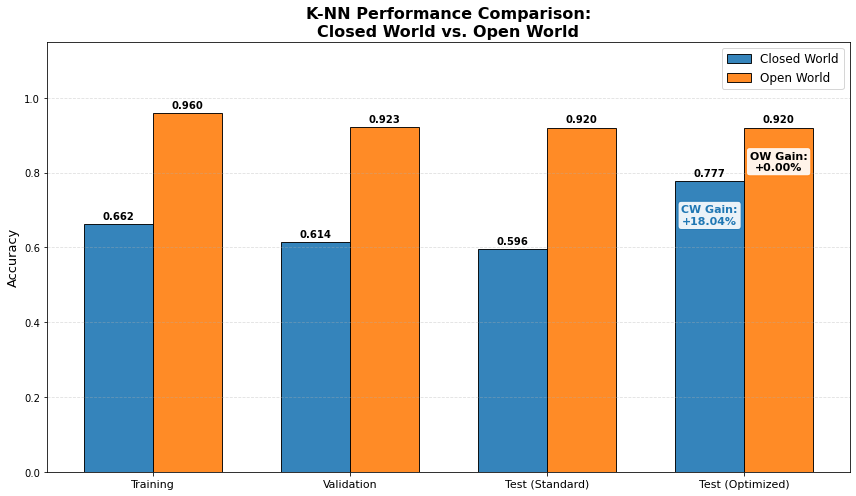

In [29]:
# --- COMPARATIVE VISUALIZATION: CLOSED WORLD VS OPEN WORLD (K-NN) ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
# Categories
categories = ['Training', 'Validation', 'Test (Standard)', 'Test (Optimized)']

# Retrieve values (Make sure all these variables are defined in your previous cells)
cw_scores = [train_acc_cw, val_acc_cw, test_acc_cw, tuned_acc_cw]
ow_scores = [train_acc_ow, val_acc_ow, test_acc_ow, tuned_acc_ow]

# 2. Setup the bar chart positions
x = np.arange(len(categories))  # Label locations
width = 0.35                    # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# 3. Create the bars
# We shift the CW bars to the left and OW bars to the right of the center tick
rects1 = ax.bar(x - width/2, cw_scores, width, label='Closed World', color='#1f77b4', edgecolor='black', alpha=0.9)
rects2 = ax.bar(x + width/2, ow_scores, width, label='Open World', color='#ff7f0e', edgecolor='black', alpha=0.9)

# 4. Add text, labels, and title
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('K-NN Performance Comparison:\nClosed World vs. Open World', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1.15) # Add headroom for labels
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 5. Function to attach a label above each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# 6. Gain calculation
# Calculate gains
gain_cw = tuned_acc_cw - test_acc_cw
gain_ow = tuned_acc_ow - test_acc_ow

# Display Box for Closed World (Blue side)
# We position it above the 4th bar group (index 3)
ax.text(x[3] - width/2, cw_scores[3] - 0.12, 
        f"CW Gain:\n{gain_cw:+.2%}", 
        ha='center', va='bottom', fontsize=11, fontweight='bold', color='#1f77b4',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#1f77b4", alpha=0.9))

# Display Box for Open World (Orange side)
# We calculate color: Red if gain > 0, Black/Grey if gain is 0 or negative
ow_text_color = '#d62728' if gain_ow > 0.0001 else 'black'
ax.text(x[3] + width/2, ow_scores[3] - 0.12, 
        f"OW Gain:\n{gain_ow:+.2%}", 
        ha='center', va='bottom', fontsize=11, fontweight='bold', color=ow_text_color,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#ff7f0e", alpha=0.9))

# 7. Show
plt.tight_layout()
plt.show()

## **SVM (Alice)**

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

print("=== CLOSED WORLD (SVM) ====")

svm_cw = SVC(
    kernel='rbf',
    gamma='scale',
    C=1.0,
    random_state=42,
    verbose=True
)

# --- Training ---
start_time = time.time()
print("Démarrage de l'entraînement...")
svm_cw.fit(X_train_cw_scaled, y_train_cw)
end_time = time.time()
print(f"Temps d'entraînement: {end_time - start_time:.2f} secondes")

# --- Predictions ---
y_train_pred_cw = svm_cw.predict(X_train_cw_scaled) # Training
y_val_pred_cw   = svm_cw.predict(X_val_cw_scaled)   # Validation
y_test_pred_cw  = svm_cw.predict(X_test_cw_scaled)  # Test

# --- Calcul accuracy ---
train_acc_cw = accuracy_score(y_train_cw, y_train_pred_cw)
val_acc_cw   = accuracy_score(y_val_cw, y_val_pred_cw)
test_acc_cw  = accuracy_score(y_test_cw, y_test_pred_cw)


print("\n--- RÉSULTATS ---")
print("Train accuracy       :", train_acc_cw)
print("Validation accuracy  :", val_acc_cw)
print("Test accuracy        :", test_acc_cw)

=== CLOSED WORLD (SVM) ====
Démarrage de l'entraînement...
[LibSVM]Temps d'entraînement: 4.98 secondes

--- RÉSULTATS ---
Train accuracy       : 0.662406015037594
Validation accuracy  : 0.6143859649122807
Test accuracy        : 0.5964912280701754


### Closed world SVM Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV

print("\n--- CLOSED WORLD SVM OPTIMIZATION (GRID SEARCH) ---")

# 1. Define parameters to test
# We limit the grid because SVM is computationally expensive on large data
param_grid_svm = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['rbf'] 
}

# 2. Run the search
grid_svm_cw = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_svm_cw.fit(X_train_cw_scaled, y_train_cw)

# 3. Retrieve the best model
best_svm_cw = grid_svm_cw.best_estimator_
tuned_acc_cw = best_svm_cw.score(X_test_cw_scaled, y_test_cw)

print(f"\nBest parameters found    : {grid_svm_cw.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_cw:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_cw:.4f}")

# 4. Display the gain
gain_cw = tuned_acc_cw - test_acc_cw
if gain_cw > 0:
    print(f"IMPROVEMENT: +{gain_cw:.4f}")
else:
    print(f"No significant improvement.")


--- CLOSED WORLD SVM OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters found    : {'C': 100, 'kernel': 'rbf'}
Accuracy WITHOUT tuning  : 0.5965
Accuracy WITH tuning     : 0.7768
IMPROVEMENT: +0.1804


In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

print("=== OPEN WORLD (SVM) ====")

svm_ow = SVC(
    kernel='rbf',
    gamma='scale',
    C=1.0,
    random_state=42,
    verbose=True
)

# --- Training ---
start_time = time.time()
print("Démarrage de l'entraînement...")
svm_ow.fit(X_train_ow_scaled, y_train_ow)
end_time = time.time()
print(f"Temps d'entraînement: {end_time - start_time:.2f} secondes")

# --- Predictions ---
y_train_pred_ow = svm_ow.predict(X_train_ow_scaled) # Training
y_val_pred_ow   = svm_ow.predict(X_val_ow_scaled)   # Validation
y_test_pred_ow  = svm_ow.predict(X_test_ow_scaled)  # Test

# --- Calcul accuracy ---
train_acc_ow = accuracy_score(y_train_ow, y_train_pred_ow)
val_acc_ow   = accuracy_score(y_val_ow, y_val_pred_ow)
test_acc_ow  = accuracy_score(y_test_ow, y_test_pred_ow)


print("\n--- RÉSULTATS ---")
print("Train accuracy       :", train_acc_ow)
print("Validation accuracy  :", val_acc_ow)
print("Test accuracy        :", test_acc_ow)


=== OPEN WORLD (SVM) ====
Démarrage de l'entraînement...
[LibSVM]Temps d'entraînement: 3.43 secondes

--- RÉSULTATS ---
Train accuracy       : 0.9937931034482759
Validation accuracy  : 0.9910344827586207
Test accuracy        : 0.9914942528735632


### Open world SVM Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

print("\n--- OPEN WORLD SVM OPTIMIZATION (GRID SEARCH) ---")
print("Warning: This process might be slow...")

# 1. Define parameters to test
# We use a limited grid to keep computation time reasonable
param_grid_svm = {
    'C': [0.1, 1, 10],   # Regularization parameter
    'kernel': ['rbf']    # RBF is usually best for this task
}

# 2. Run the search
# cv=3 is used for speed. n_jobs=-1 uses all CPU cores.
grid_svm_ow = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_svm_ow.fit(X_train_ow_scaled, y_train_ow)

# 3. Retrieve the best model
best_svm_ow = grid_svm_ow.best_estimator_
tuned_acc_ow = best_svm_ow.score(X_test_ow_scaled, y_test_ow)

print(f"\nBest parameters found    : {grid_svm_ow.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_ow:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_ow:.4f}")

# 4. Display the gain
gain_ow = tuned_acc_ow - test_acc_ow
if gain_ow > 0:
    print(f"IMPROVEMENT: +{gain_ow:.4f}")
else:
    print(f"No significant improvement.")


--- OPEN WORLD SVM OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters found    : {'C': 10, 'kernel': 'rbf'}
Accuracy WITHOUT tuning  : 0.9915
Accuracy WITH tuning     : 0.9938
IMPROVEMENT: +0.0023


### Comparaison SVM closed and open world without and with Hyperparameter Tuning

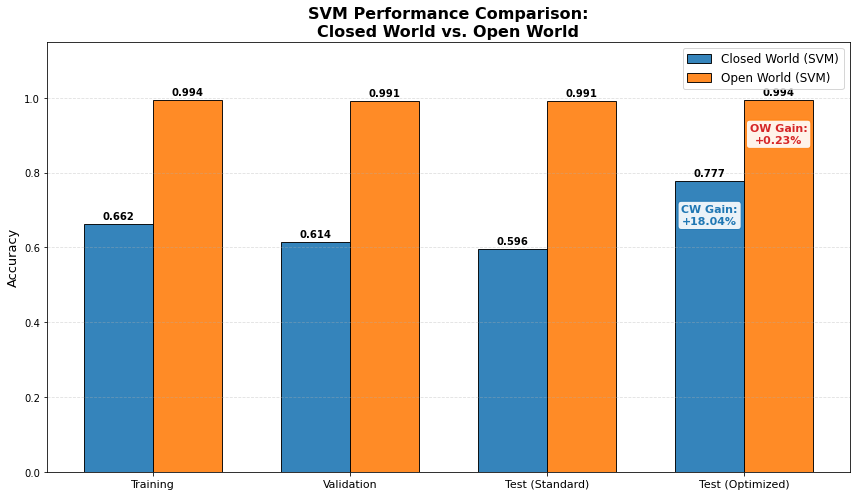

In [19]:
# --- COMPARATIVE VISUALIZATION: CLOSED WORLD VS OPEN WORLD (SVM) ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
# Categories
categories = ['Training', 'Validation', 'Test (Standard)', 'Test (Optimized)']

# Retrieve values (Ensure you have run the SVM GridSearch blocks before this)
# If you haven't run the tuning, these variables (tuned_*) might be missing
cw_scores_svm = [train_acc_cw, val_acc_cw, test_acc_cw, tuned_acc_cw]
ow_scores_svm = [train_acc_ow, val_acc_ow, test_acc_ow, tuned_acc_ow]

# 2. Setup the bar chart positions
x = np.arange(len(categories))  # Label locations
width = 0.35                    # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# 3. Create the bars
# Closed World (Blue)
rects1 = ax.bar(x - width/2, cw_scores_svm, width, label='Closed World (SVM)', color='#1f77b4', edgecolor='black', alpha=0.9)
# Open World (Orange)
rects2 = ax.bar(x + width/2, ow_scores_svm, width, label='Open World (SVM)', color='#ff7f0e', edgecolor='black', alpha=0.9)

# 4. Add text, labels, and title
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('SVM Performance Comparison:\nClosed World vs. Open World', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1.15) # Add headroom for labels
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 5. Function to attach a label above each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# 6. Gain calculation
# Calculate gains
gain_cw = tuned_acc_cw - test_acc_cw
gain_ow = tuned_acc_ow - test_acc_ow

# Display Box for Closed World
ax.text(x[3] - width/2, cw_scores_svm[3] - 0.12, 
        f"CW Gain:\n{gain_cw:+.2%}", 
        ha='center', va='bottom', fontsize=11, fontweight='bold', color='#1f77b4',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#1f77b4", alpha=0.9))

# Display Box for Open World
# If gain is practically 0, color is black, otherwise red
ow_text_color = '#d62728' if gain_ow > 0.0001 else 'black'

ax.text(x[3] + width/2, ow_scores_svm[3] - 0.12, 
        f"OW Gain:\n{gain_ow:+.2%}", 
        ha='center', va='bottom', fontsize=11, fontweight='bold', color=ow_text_color,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#ff7f0e", alpha=0.9))

# 7. Show
plt.tight_layout()
plt.show()

### Tree ensembles (Maya)

In [30]:
# ----- Closed world ------
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import accuracy_score

df = pd.DataFrame(X_train_cw_scaled)
df.head()

# Can change the n_estimators here
clf_cw = RandomForestClassifier(n_estimators=1000, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=0)

# k-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf_cw, X_train_cw_scaled, y_train_cw, cv=5)
print("Accuracies:", scores)
print("Average accuracy:", sum(scores)/len(scores))

clf_cw.fit(X_train_cw_scaled, y_train_cw)

# Test accuracy
y_pred_test_rf = clf_cw.predict(X_test_cw_scaled)
test_accuracy_rf = accuracy_score(y_test_cw, y_pred_test_rf)

print(f"Test Accuracy (Closed world): {test_accuracy_rf}")

KeyboardInterrupt: 

In [ ]:
# ---- Feature importance (closed world) ----
imp_score=clf_cw.feature_importances_

#pick top 5 features
import numpy as np

# np.argsort returns "indices" in ascending order
# X[::-1]: reverse X
top_indices=np.argsort(imp_score)[::-1][:5]
print(top_indices)
top_feature_names=[feature_names[int(x)] for x in top_indices]
print(top_feature_names)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

feature_imp = pd.Series(clf_cw.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp.head(20), y=feature_imp.head(20).index, hue=feature_imp.head(20).index, palette='viridis', legend=False)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Top 20 Important Features")
plt.tight_layout()

In [ ]:
# ----- Open world ------
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

df = pd.DataFrame(X_train_ow_scaled)
df.head()

# Can change the n_estimators here
clf_ow = RandomForestClassifier(n_estimators=1000, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=0)

# k-fold cross validation
scores_ow = cross_val_score(clf_ow, X_train_ow_scaled, y_train_ow, cv=5)
print("Accuracies:", scores_ow)
print("Average accuracy:", sum(scores_ow)/len(scores_ow))

clf_ow.fit(X_train_ow_scaled, y_train_ow)

# Test accuracy
y_pred_test_rf_ow = clf_ow.predict(X_test_ow_scaled)
test_accuracy_rf_ow = accuracy_score(y_test_ow, y_pred_test_rf_ow)

print(f"Test Accuracy (Open World): {test_accuracy_rf_ow}")

In [ ]:
# ---- Feature importance (open world) ----
imp_score=clf_ow.feature_importances_

#pick top 5 features
import numpy as np

# np.argsort returns "indices" in ascending order
# X[::-1]: reverse X
top_indices=np.argsort(imp_score)[::-1][:5]
print(top_indices)
top_feature_names=[feature_names[int(x)] for x in top_indices]
print(top_feature_names)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

feature_imp = pd.Series(clf_ow.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp.head(20), y=feature_imp.head(20).index, hue=feature_imp.head(20).index, palette='viridis', legend=False)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Top 20 Important Features")
plt.tight_layout()